In [ ]:
# Invoice Risk & Vendor Exposure Analysis

# This project analyzes invoice payment data to identify unpaid balances,
# vendor risk exposure, and escalation priorities using Python and Pandas.
# Synthetic invoice dates were derived from days overdue to enable
# time-based analysis.

# Data Assumptions:
# Invoice dates were derived using days overdue
# Unpaid invoices represent active financial exposure
# Priority levels reflect escalation urgency

In [1]:
# Generate invoices for the project.

import random

invoices = [
    {"id": "INV001", "vendor": "Amazon", "amount": 450,  "status": "Paid",   "days_overdue": 0},
    {"id": "INV002", "vendor": "Staples","amount": 1200, "status": "Unpaid", "days_overdue": 18},
    {"id": "INV003", "vendor": "FedEx",  "amount": 300,  "status": "Unpaid", "days_overdue": 5},
    {"id": "INV004", "vendor": "UPS",    "amount": 800,  "status": "Paid",   "days_overdue": 0},
    {"id": "INV005", "vendor": "Amazon", "amount": 650,  "status": "Unpaid", "days_overdue": 45},
    {"id": "INV006", "vendor": "Dell",   "amount": 2000, "status": "Unpaid", "days_overdue": 2},
]


random.seed(42)  # ensures reproducibility

vendors = ["Amazon", "Staples", "FedEx", "UPS", "Dell", "Office Depot", "Walmart", "Costco", "Best Buy", "Grainger"]
statuses = ["Paid", "Unpaid"]

starting_id = len(invoices) + 1
target_size = 200

while len(invoices) < target_size:
    invoice_id = f"INV{starting_id:03d}"
    vendor = random.choice(vendors)

    # realistic amounts
    amount = random.randint(50, 5000)

    # weighted status (more paid than unpaid)
    status = "Unpaid" if random.random() < 0.35 else "Paid"

    # enforce business logic
    if status == "Paid":
        days_overdue = 0
    else:
        days_overdue = random.randint(1, 90)

    invoices.append({
        "id": invoice_id,
        "vendor": vendor,
        "amount": amount,
        "status": status,
        "days_overdue": days_overdue
    })

    starting_id += 1


In [4]:
# Import libraries used for analysis.

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Load the invoices into a dataframe.

df = pd.DataFrame(invoices)

# Generate an invoice date column based on the current date minus the days overdue.

df['invoice_date'] = df['days_overdue'].apply(lambda x: (datetime.now() - timedelta(days=x)).strftime('%Y-%m-%d'))

df = df.sort_values('invoice_date')

,id,vendor,amount,status,days_overdue,invoice_date
116,INV117,Walmart,2082,Unpaid,90,2025-09-25
148,INV149,Staples,3532,Unpaid,90,2025-09-25
169,INV170,Amazon,3235,Unpaid,87,2025-09-28
140,INV141,FedEx,744,Unpaid,85,2025-09-30
72,INV073,Costco,4558,Unpaid,84,2025-10-01
...,...,...,...,...,...,...
103,INV104,Amazon,806,Paid,0,2025-12-24
102,INV103,Dell,4190,Paid,0,2025-12-24
46,INV047,FedEx,3113,Paid,0,2025-12-24
32,INV033,UPS,4648,Paid,0,2025-12-24


In [9]:
# Priority Mapping

# Creating a priority column to identify high and medium risk invoices based on unpaid status, unpaid amount, and days overdue.

df['priority'] = np.select(
    [
        (df['status'] == 'Unpaid') & ((df['amount'] > 1000) | (df['days_overdue'] > 30)),
        (df['status'] == 'Unpaid')
    ],
    ['HIGH', 'MEDIUM'],
    default='NONE'
)

# Risk Scoring

risk_map = {'HIGH' : 3, 'MEDIUM' : 2, 'NONE' : 1}
df['risk_score'] = df['priority'].map(risk_map)

df

,id,vendor,amount,status,days_overdue,invoice_date,priority,risk_score
116,INV117,Walmart,2082,Unpaid,90,2025-09-25,HIGH,3
148,INV149,Staples,3532,Unpaid,90,2025-09-25,HIGH,3
169,INV170,Amazon,3235,Unpaid,87,2025-09-28,HIGH,3
140,INV141,FedEx,744,Unpaid,85,2025-09-30,HIGH,3
72,INV073,Costco,4558,Unpaid,84,2025-10-01,HIGH,3
...,...,...,...,...,...,...,...,...
103,INV104,Amazon,806,Paid,0,2025-12-24,NONE,1
102,INV103,Dell,4190,Paid,0,2025-12-24,NONE,1
46,INV047,FedEx,3113,Paid,0,2025-12-24,NONE,1
32,INV033,UPS,4648,Paid,0,2025-12-24,NONE,1


In [11]:
# Vendor Risk KPI Table

vendor_risk_kpi = (
    df[df['status'] == 'Unpaid']
    .groupby('vendor')
    .agg(
        total_unpaid_amount = ('amount','sum'),
        unpaid_invoice_count = ('id','count'),
        avg_days_overdue = ('days_overdue',lambda x: round(x.mean(),2)),
        high_risk_count = ('priority', lambda x: (x == 'HIGH').sum())

    )
    .sort_values('total_unpaid_amount', ascending=False)
    .reset_index()
)
vendor_risk_kpi

,vendor,total_unpaid_amount,unpaid_invoice_count,avg_days_overdue,high_risk_count
0,Best Buy,36578,11,41.00,10
1,Dell,35141,11,31.64,10
2,Staples,26397,9,56.11,9
3,FedEx,22452,10,37.30,9
4,UPS,21420,7,43.14,7
5,Walmart,21021,6,31.33,6
6,Costco,19839,6,50.00,6
7,Grainger,15108,7,40.43,6
8,Amazon,14540,7,37.71,6
9,Office Depot,7249,4,22.75,2


In [22]:
# Ranking & Exposure Analysis

# Creating a column to rank the risk level of each vendor based on the total unpaid amount.

vendor_risk_kpi['exposure_rank'] = (
    vendor_risk_kpi['total_unpaid_amount']
    .rank(method = 'dense', ascending = False)
    .astype(int)
)

# Set the new exposure rank column as the index column.

vendor_risk_kpi.set_index('exposure_rank', inplace=True)

vendor_risk_kpi

,vendor,total_unpaid_amount,unpaid_invoice_count,avg_days_overdue,high_risk_count
exposure_rank,,,,,
1,Best Buy,36578,11,41.00,10
2,Dell,35141,11,31.64,10
3,Staples,26397,9,56.11,9
4,FedEx,22452,10,37.30,9
5,UPS,21420,7,43.14,7
6,Walmart,21021,6,31.33,6
7,Costco,19839,6,50.00,6
8,Grainger,15108,7,40.43,6
9,Amazon,14540,7,37.71,6


In [23]:
# Top 5 Vendors by Risk Exposure

top_5_vendors = vendor_risk_kpi.head(5)
top_5_vendors

,vendor,total_unpaid_amount,unpaid_invoice_count,avg_days_overdue,high_risk_count
exposure_rank,,,,,
1,Best Buy,36578,11,41.00,10
2,Dell,35141,11,31.64,10
3,Staples,26397,9,56.11,9
4,FedEx,22452,10,37.30,9
5,UPS,21420,7,43.14,7


<Axes: xlabel='vendor'>

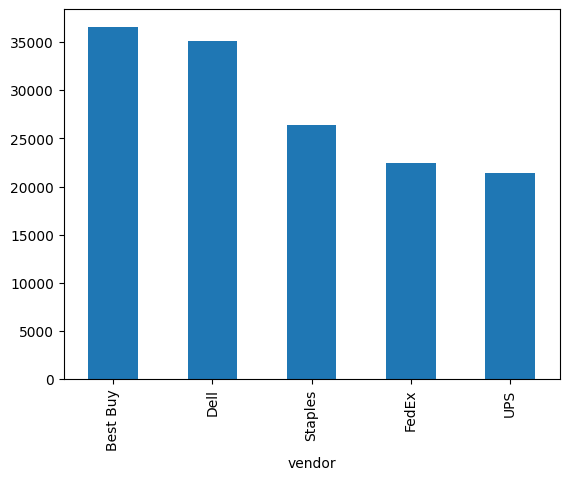

In [50]:
# Visualization of Top 5 Vendors by Risk Exposure.

top_5_vendors.plot(
    x='vendor',
    y='total_unpaid_amount',
    kind='bar',
    legend=False
)


In [27]:
# Aging & Early Warning Indicators

# Created column that separates invoices into bins based on days overdue.

df['aging_bucket'] = pd.cut(
    df['days_overdue'],
    bins=[-1,0,30,60,90,float('inf')],
    labels=['Current','0-30', '31-60', '61-90', '90+']
)

# Summarized the aging buckets into a table showing the total amount and invoice count for each bucket.

aging_bucket_table = (
    df.groupby('aging_bucket')
    .agg(
        total_amount = ('amount','sum'),
        invoice_count = ('id','count')
    )
    .reset_index()
)

aging_bucket_table

/tmp/ipython-input-2250241959.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('aging_bucket')


,aging_bucket,total_amount,invoice_count
0,Current,278551,122
1,0-30,90069,34
2,31-60,78429,26
3,61-90,51247,18
4,90+,0,0


<Axes: title={'center': 'Total Amount by Aging Bucket'}, xlabel='Aging Bucket', ylabel='Total Amount'>

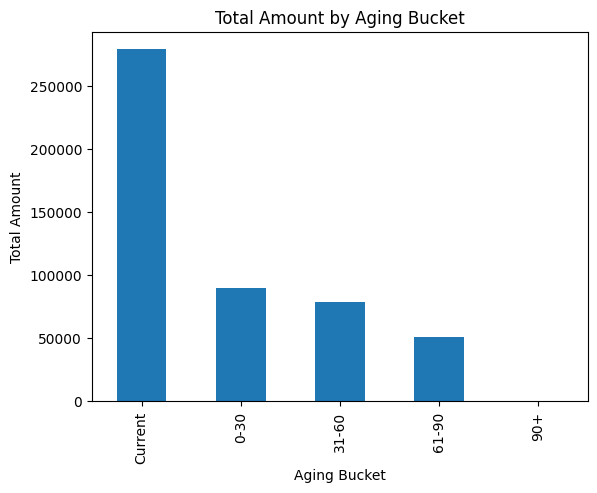

In [40]:
# Vizualization of the total amounts for each aging bucket.

aging_bucket_table.plot(
    x='aging_bucket',
    y='total_amount',
    kind='bar',
    title='Total Amount by Aging Bucket',
    xlabel='Aging Bucket',
    ylabel='Total Amount',
    legend=False,
)


In [60]:
# Created a column that will flag a vendor if their high risk count exceeds 6 invoices.

vendor_risk_kpi["escalation_flag"] = np.where(
    vendor_risk_kpi["high_risk_count"] > 2,
    "ESCALATE",
    "MONITOR"
)

vendor_risk_kpi

,vendor,total_unpaid_amount,unpaid_invoice_count,avg_days_overdue,high_risk_count,escalation_flag
exposure_rank,,,,,,
1,Best Buy,36578,11,41.00,10,ESCALATE
2,Dell,35141,11,31.64,10,ESCALATE
3,Staples,26397,9,56.11,9,ESCALATE
4,FedEx,22452,10,37.30,9,ESCALATE
5,UPS,21420,7,43.14,7,ESCALATE
6,Walmart,21021,6,31.33,6,ESCALATE
7,Costco,19839,6,50.00,6,ESCALATE
8,Grainger,15108,7,40.43,6,ESCALATE
9,Amazon,14540,7,37.71,6,ESCALATE


<Axes: title={'center': 'Escalation Flag Distribution'}>

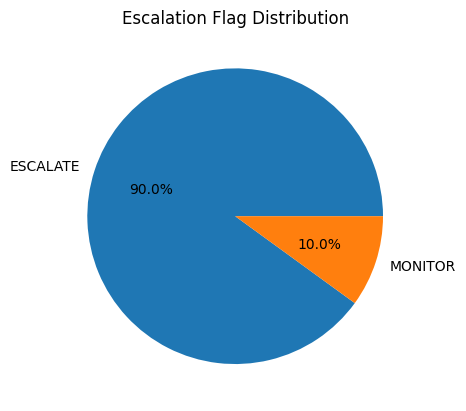

In [63]:
# Visualized the distribution of escalation flags.

escalation_count = vendor_risk_kpi['escalation_flag'].value_counts()
escalation_count

escalation_count.plot(
    kind='pie',
    autopct='%1.1f%%',
    title='Escalation Flag Distribution',
    ylabel=''
)

In [ ]:
# Summary

# 1. Identified vendors with highest unpaid financial exposure.
# 2. Ranked vendors based on unpaid balances and risk indicators.
# 3. Flagged vendors requiring escalation due to high-risk invoices.
# 4. Created aging analysis to highlight overdue concentration.
# 5. Visualized the top 5 vendors with highest exposure.
# 6. Visualized the risk exposure amount separated into aging buckets.
# 7. Visualized the escalation flag distribution to show the breakdown of vendors that need to resolved immediately.